In [1]:
# Set up free personal Alpaca API key before executing the script
API_KEY = "YOUR_API_KEY"
SECRET_KEY = "YOUR_SECRET_KEY"
BASE_URL = "https://paper-api.alpaca.markets"
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import importlib
import functions
importlib.reload(functions)
from functions import add_lagged_features_regression
from functions import get_data
from functions import save_target
from functions import predict_stocks_random_forest
from functions import predict_stocks_xgboost
import xgboost as xgb
import pandas as pd
import numpy as np
import math

In [2]:
# Avoid stocks that have split or moved drasticially recently
tickers = [
    'JPM', 'BAC', 'MS', 'AFL', 'RF',              # Financials
    'JNJ', 'PFE', 'MRK', 'VRTX', 'DVA',           # Health Care
    'AAPL', 'MSFT', 'ADBE', 'CDW',        # Technology
    'BA', 'GE', 'ETN', 'PCAR', 'ALLE',            # Industrials
    'XOM', 'CVX', 'EOG', 'PSX', 'SLB',            # Energy
    'V', 'NEM', 'IFF', 'ALB', 'PKG',            # Materials
    'AMZN', 'TSLA', 'HD', 'NKE', 'LKQ',           # Consumer Discretionary
    'PG', 'KO', 'WMT', 'KHC', 'CPB',              # Consumer Staples
    'GOOGL', 'META', 'T', 'VZ', 'FOXA',           # Communication Services
    'PLD', 'AMT', 'DLR',                          # Real Estate
    'NEE', 'DUK', 'AEP'                           # Utilities
]
days = 250
stocks_data = get_data(tickers, days = days)   # 250 days for training
stocks_data['V'] # Ensure there are 271 rows

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,V,2024-07-01 04:00:00+00:00,263.79,265.770,261.3000,263.24,7955766.0,118044.0,262.928288
1,V,2024-07-02 04:00:00+00:00,263.24,268.230,262.4000,268.23,8697811.0,102376.0,266.655477
2,V,2024-07-03 04:00:00+00:00,269.07,269.750,268.1500,268.99,5017760.0,69011.0,268.956028
3,V,2024-07-05 04:00:00+00:00,269.00,270.545,268.2400,270.36,7986435.0,94254.0,270.043318
4,V,2024-07-08 04:00:00+00:00,270.25,271.440,265.9700,266.40,8561140.0,101859.0,267.186092
...,...,...,...,...,...,...,...,...,...
266,V,2025-07-24 04:00:00+00:00,354.82,357.180,353.8600,353.97,5887647.0,99278.0,355.016972
267,V,2025-07-25 04:00:00+00:00,354.00,357.650,353.0100,357.04,3915781.0,86642.0,356.226916
268,V,2025-07-28 04:00:00+00:00,356.38,358.320,354.7300,355.47,3920959.0,92926.0,355.980296
269,V,2025-07-29 04:00:00+00:00,356.29,358.320,350.8095,351.29,7402324.0,138918.0,353.305957


In [3]:
sp500_ticker = 'SPY'
sp500_data = get_data(sp500_ticker, days)

In [4]:
# Find S&P 500's daily movement and volume
sp500_data['SPY']['target_sp500'] = sp500_data['SPY']['close'].pct_change().shift(1)

# Add features relative to the general market (S&P500)
for key, df in stocks_data.items():
    df = df.merge(sp500_data['SPY'][['timestamp', 'target_sp500']], on='timestamp')
    stocks_data[key] = df

# Saves the lastest target value for every ticker for evaluations 
stocks_target = save_target(stocks_data)

# Add lagged features (see other file)
for key in stocks_data:
    stocks_data[key] = add_lagged_features_regression(stocks_data[key])

In [5]:
stocks_data['V'] # Ensure there are 271 rows
#stocks_data['JPM'].to_csv('JPM_stock_data.csv', index=True)

,symbol,timestamp,close_lag1,close_lag2,close_lag3,open_lag1,open_lag2,open_lag3,volume_lag1,volume_lag2,...,return_10d,target,relative_return_1d,rolling_corr_10,return_vs_sp500,price_vs_upper_band,price_vs_lower_band,return_skew_5d,stoch_k,price_accel
0,V,2024-07-30 04:00:00+00:00,261.60,259.46,253.74,260.32,255.59,255.39,6068109.0,7062213.0,...,-0.025517,0.009768,0.007660,0.731509,14.008936,0.951334,1.025638,-0.782843,0.425430,-3.58
1,V,2024-07-31 04:00:00+00:00,263.10,261.60,259.46,263.23,260.32,255.59,5941775.0,6068109.0,...,-0.022841,0.000979,0.010800,0.724482,-1.131971,0.956794,1.031569,-0.779767,0.497132,-0.64
2,V,2024-08-01 04:00:00+00:00,265.67,263.10,261.60,264.54,263.23,260.32,7642547.0,5941775.0,...,-0.025779,0.002444,-0.006486,0.714708,0.600909,0.966973,1.041725,-1.448528,0.619981,1.07
3,V,2024-08-02 04:00:00+00:00,265.93,265.67,263.10,266.33,264.54,263.23,7269671.0,7642547.0,...,-0.011964,-0.038037,0.015140,0.874141,-0.069114,0.969075,1.042655,0.796356,0.632409,-2.31
4,V,2024-08-05 04:00:00+00:00,266.58,265.93,265.67,263.83,266.33,264.54,7017857.0,7269671.0,...,0.004219,0.007097,0.021063,0.791850,-0.131288,0.973250,1.044667,1.266983,0.663480,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,V,2025-07-24 04:00:00+00:00,355.29,351.86,350.94,353.00,351.10,349.06,4385600.0,4614217.0,...,-0.006904,0.008673,0.001241,0.714571,1.145706,0.986415,1.033180,0.203558,0.713771,2.51
247,V,2025-07-25 04:00:00+00:00,353.97,355.29,351.86,354.82,353.00,351.10,5887647.0,4385600.0,...,-0.005367,-0.004397,-0.004046,0.715270,-11.186523,0.983243,1.026204,0.515261,0.627313,-4.75
248,V,2025-07-28 04:00:00+00:00,357.04,353.97,355.29,354.00,354.82,353.00,3915781.0,5887647.0,...,0.026183,-0.011759,0.004449,0.749433,2.052632,0.991303,1.032317,0.267579,0.911039,4.39
249,V,2025-07-29 04:00:00+00:00,355.47,357.04,353.97,356.38,354.00,354.82,3920959.0,3915781.0,...,0.014180,-0.001082,-0.004146,0.740852,17.579364,0.986651,1.026061,-0.950793,0.795369,-4.64


In [6]:
stocks_predictions = predict_stocks_random_forest(stocks_data, days = days, threshold = 0)

--- Model Performance Summary ---
Mean Squared Error (MSE):       0.000730
Root Mean Squared Error (RMSE): 0.027026
Mean Absolute Error (MAE):      0.019982
Directional Accuracy:           60.00%
---------------------------------


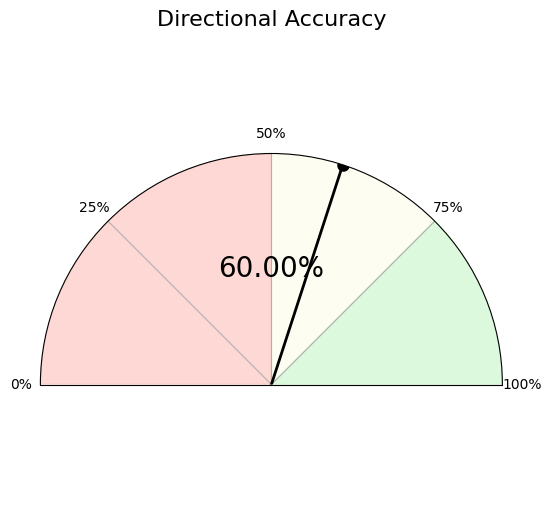

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Ensure tickers are in the same order for prediction and target lists
tickers = list(stocks_predictions.keys())
preds = [stocks_predictions[ticker][0] for ticker in tickers]
targets = [stocks_target[ticker] for ticker in tickers]

# Calculate metrics
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets, preds)

# Calculate Directional Accuracy
correct_direction = 0
for i in range(len(preds)):
    if (preds[i] > 0 and targets[i] > 0) or \
       (preds[i] < 0 and targets[i] < 0) or \
       (preds[i] == 0 and targets[i] == 0): # Handle exact zeros correctly
        correct_direction += 1
directional_accuracy = (correct_direction / len(preds)) * 100 if len(preds) > 0 else 0

# Text Summary of Metrics
print("--- Model Performance Summary ---")
print(f"Mean Squared Error (MSE):       {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE):      {mae:.6f}")
print(f"Directional Accuracy:           {directional_accuracy:.2f}%")
print("---------------------------------")

# Gauge Chart for Directional Accuracy
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Set properties for the gauge
max_angle = np.pi  # Half circle (0 to 180 degrees)
# Directional Accuracy will range from 0 to 100%
# Map 0-100% to 0-pi radians
angle = (directional_accuracy / 100) * max_angle

# FIX: Changed 'left' to 'W' (West) for correct zero location
ax.set_theta_zero_location('W')  # Start from the left (0 degrees, West)
ax.set_theta_direction(-1)       # Clockwise
ax.set_rticks([])                # Remove radial ticks
ax.set_ylim(0, 1)                # Set radial limits to 0-1 for needle

# Set the limits for the angular axis
ax.set_thetalim(0, max_angle)
# Set the labels for the angular axis (0%, 25%, 50%, 75%, 100%)
ax.set_xticks(np.linspace(0, max_angle, 5))
ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

# Plot the colored background (optional, for visual ranges)
ax.axvspan(0, max_angle * 0.5, color='salmon', alpha=0.3, zorder=0) # 0-50% (red)
ax.axvspan(max_angle * 0.5, max_angle * 0.75, color='lightgoldenrodyellow', alpha=0.3, zorder=0) # 50-75% (yellow)
ax.axvspan(max_angle * 0.75, max_angle, color='lightgreen', alpha=0.3, zorder=0) # 75-100% (green)


# Plot the needle
ax.plot([0, angle], [0, 1], color='black', linewidth=2, linestyle='-')
ax.plot(angle, 1, marker='o', markersize=8, color='black') # Needle head

# Add text for the current accuracy
# Use fig.transFigure for positioning relative to the whole figure, or ax.transAxes for relative to subplot
ax.text(0.5, 0.5, f'{directional_accuracy:.2f}%',
        horizontalalignment='center', verticalalignment='center',
        fontsize=20, transform=ax.transAxes) # transform=ax.transAxes positions relative to the axes

ax.set_title('Directional Accuracy', va='bottom', fontsize=16)
plt.show()

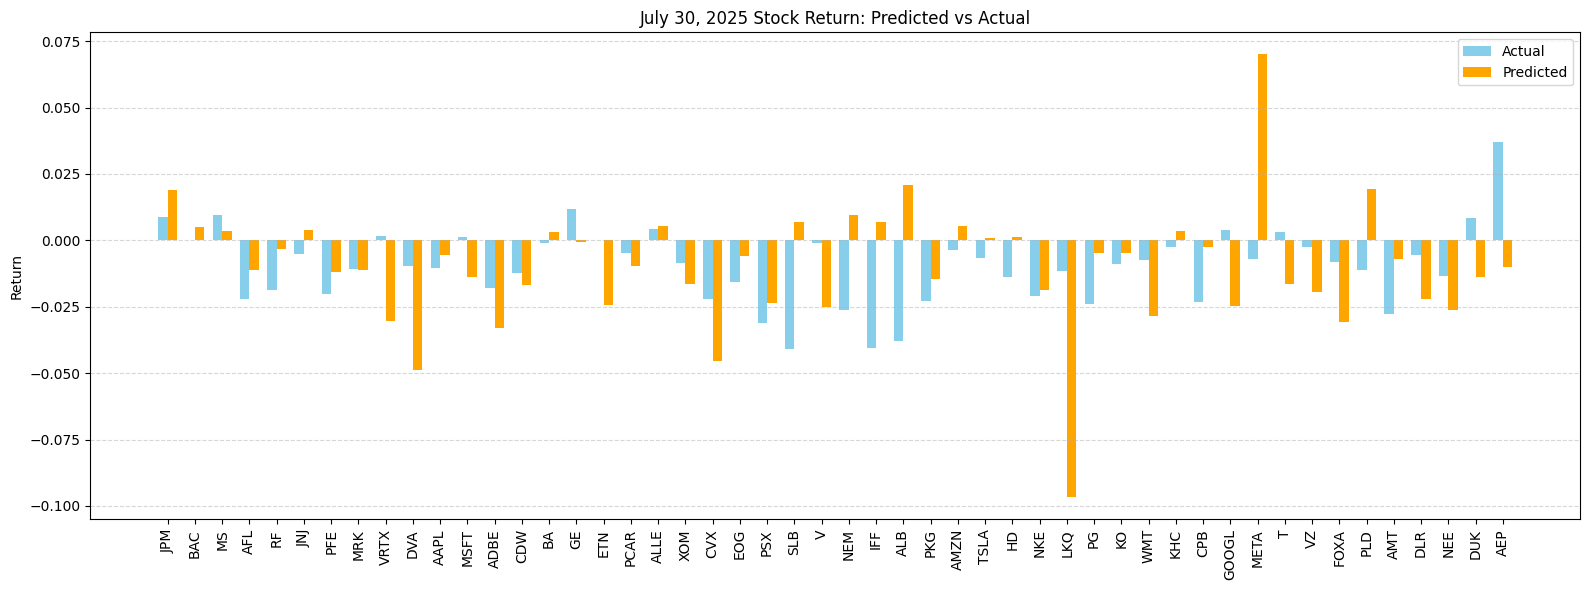

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Find date of prediction
end_date = datetime.now() - timedelta(days=1)

# Format the datetime object to "YYYY Month DD"
formatted_date = end_date.strftime("%B %d, %Y")

# Convert predictions and targets to flat lists
tickers = list(stocks_predictions.keys())
preds = [stocks_predictions[ticker][0] for ticker in tickers]
targets = [stocks_target[ticker] for ticker in tickers]

x = np.arange(len(tickers))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 6))
rects1 = ax.bar(x - width/2, targets, width, label='Actual', color='skyblue')
rects2 = ax.bar(x + width/2, preds, width, label='Predicted', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Return')
ax.set_title(f'{formatted_date} Stock Return: Predicted vs Actual')
ax.set_xticks(x)
ax.set_xticklabels(tickers, rotation=90)
ax.legend()

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

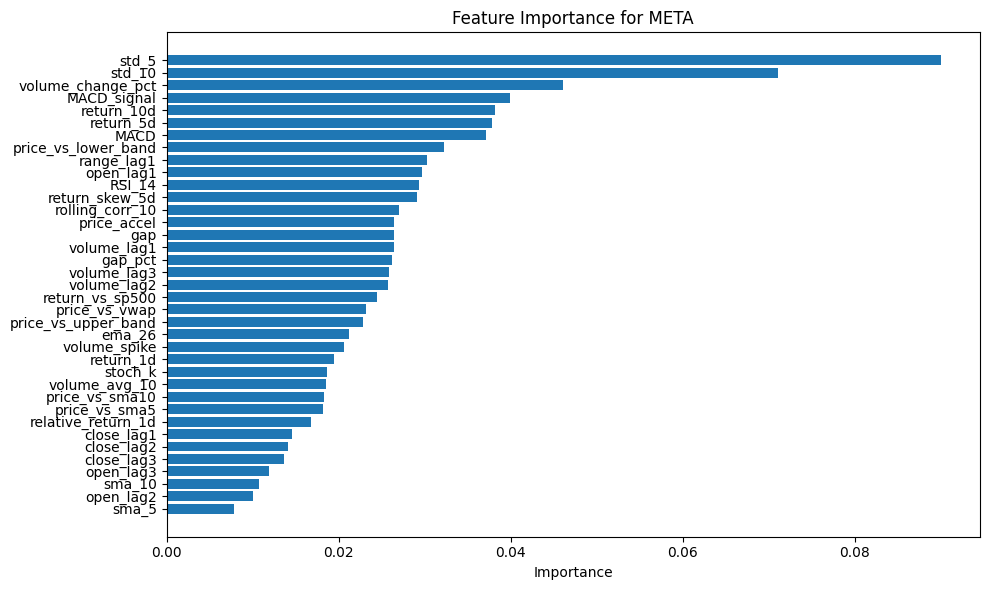

In [9]:
# Find feature importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

def predict_stocks_random_forest_local(data, days):
    stock_predictions = {}
    trained_models = {}
    feature_names_dict = {}

    for key, df in data.items():
        features = [col for col in df.columns if col not in ['symbol', 'timestamp', 'target']]
        X = df[features].values
        y = df['target'].values

        if len(X) <= days:
            continue  # Skip if there's not enough data

        X_train = X[:days]
        y_train = y[:days]
        X_test = X[days:days + 1]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)

        prediction = model.predict(X_test_scaled)
        stock_predictions[key] = prediction
        trained_models[key] = model
        feature_names_dict[key] = features

    return stock_predictions, trained_models, feature_names_dict

stocks_predictions, trained_models, feature_names_dict = predict_stocks_random_forest_local(stocks_data, days=days)

import matplotlib.pyplot as plt
import pandas as pd

# Choose a stock to visualize
stock_key = 'META' 

model = trained_models[stock_key]
features = feature_names_dict[stock_key]
importances = model.feature_importances_

# Make DataFrame for plotting
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title(f'Feature Importance for {stock_key}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()